# Met Office Aircraft Data Exploration

---

In this notebook, aircraft data is taken from the CEDA data archive programmatically. The sources of this data are: the FAAM repository and the repository of the Meteorological Research Flight (MRF) facility. MRF data is held in the Nasa Ames format, and the chosen FAAM data that is downloaded will be netCDF. The data is explored by the means of some basic visualizations

## Contents
- netCDF
    - Scrape CEDA
        - download the links
    - Explore the downloaded data
- Nasa Ames
    - Download as before
    - Explore
-
-

In [9]:
import iris
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob

from bs4 import BeautifulSoup
import requests
import os
import sys

# clear cell outputs when private information is displayed
from IPython.display import clear_output
HIDE_SECRET_OUTPUT = True

In [2]:
# read environment file
env_vars = {}

with open(".env") as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        env_vars[key] = value

print(env_vars)
if HIDE_SECRET_OUTPUT:
    clear_output()

In [3]:
# load environment variables
CERT_SECRET = env_vars["CEDA_CERTIFICATE_DIRECTORY"]

### Scraping a CEDA repository

Scraping is the process of extracting data from websites, this is typically done in an automatic way with a "web crawler". Below a web crawler for a specified repository is defined.

The key tools to perform this crawl are: a [Recursive](https://en.wikipedia.org/wiki/Recursion_%28computer_science%29) implementation of [Depth-First-Search](https://en.wikipedia.org/wiki/Depth-first_search), html parser [Beautiful Soup](https://beautiful-soup-4.readthedocs.io/en/latest/), permission to search the repository (using the CEDA generated certificate), and some knowledge about the setup of the repository.

The result of this web crawl will be the links for all of the 1hz netCDF files in the FAAM data repository. the FAAM data repository has many different file extensions for the data: \[.zip, .txt, .html, .pdf, .kml, .ict, .dat, .xls, .ps, .na, and .nc\] . There also exist categories of data sorted into directories, e.g. directories with 'raw' in the name have not gone through any processing, so are ignored as this data is likely to be hard to handle. All forms of undesired data are ignored in the crawl, going down directories and pulling only the files specifically named after the 1hz data format. The 1hz data format is arguably the easiest data to handle.

In [4]:
cert_dir = CERT_SECRET # certificate file location generated by https://help.ceda.ac.uk/article/4442-ceda-opendap-scripted-interactions
visited_urls = set() # global sets to allow access in functions during recursion
download_links = set()
start_data_dir = './data/aircraft_data/netcdf_example' # root directory for downloaded content

def crawl_directory(url, start_data_dir):
    if url in visited_urls:
        return
    
    visited_urls.add(url)
    
    response = requests.get(url, cert=(cert_dir))
    
    soup = BeautifulSoup(response.content, 'html.parser') # parse the content, returns soup object
    
    if soup is None: # if nothing is found in the htmlparse, end
        return
    
#     os.makedirs(os.path.dirname(start_data_dir), exist_ok=True) # CREATE A NEW DIRECTORY/subdirectory in the download folder FOR EACH DIRECTORY ONLINE
    
#     with open(os.path.join(start_data_dir, 'page.html'), "w", errors='ignore') as f:   # WRITE THE CONTENTS OF THE DIRECTORY IN THE DIRECTORY WITH A PAGE.HTML FILE FOR NAVIGATION
#         f.write(str(soup))                                                             # (does not work without previous os.makdirs in most cases)
    
    for link in soup.find_all('a'):#hrefs exist in anchor elements
        if link.has_attr('href'):
            href = link['href'] #only explore links
        else:
            continue
        
        if(
            href == '../' 
        ): # don't go up in directories
            continue
        elif(href.endswith('/')): # if the link is a further directory
            if(
                'non' in href
                or href=='core_processed_standard/'
                or href=='core_processed_cloud_physics/'
                or 'temp' in href
                or 'raw' in href
                or 'video' in href
            ): # ignore known undesirable directories in our specific use-case
                continue
            if(len(href)==5): # print hrefs that are years just for easy progress tracking
                print("Looking in year:", href)
                if href == '2004/' or href == '2005/' or href == '2006/': #doesn't contain any desired files
                    continue
            # look in the directory
            crawl_directory(os.path.join(url, href), os.path.join(start_data_dir, href))
        elif(href.endswith('1hz.nc')): # save diserable files
            
            #don't download if there is a more recent version
            all_links = soup.find_all('a')
            all_hrefs = list([ link['href'] for link in all_links ])
            all_1hz = [desired_nc_file for desired_nc_file in all_hrefs if '1hz.nc' in desired_nc_file]
            # add all the 1hz files in this directory to the visited urls section (duplicates current href, but doesn't cause issue)
            for nc_1hz in all_1hz:
                visited_urls.add(os.path.join(url, nc_1hz))
            #add only the most recent revision to links that are kept
            all_1hz = sorted(all_1hz)
            most_recent_1hz = all_1hz[-1]
            download_links.add(os.path.join(url, most_recent_1hz)) # if chosen to mirror the directory setup as is online, good idea to just download the file instead of save download link
    
file_start_url = 'https://dap.ceda.ac.uk/badc/faam/data'
print('starting crawl')
crawl_directory(file_start_url, start_data_dir)
print('crawl end')
#convert 1hz.nc set to sorted list (sorts by year, then alphabetically on ?flightcode?)
download_links = sorted(list(download_links), reverse=True) # reverse to make recent data appear first in the list

# print(download_links)
print(len(download_links), "files found.")

starting crawl
Looking in year: 2004/
Looking in year: 2005/
Looking in year: 2006/
Looking in year: 2007/
Looking in year: 2008/
Looking in year: 2009/
Looking in year: 2010/
Looking in year: 2011/
Looking in year: 2012/
Looking in year: 2013/
Looking in year: 2014/
Looking in year: 2015/
Looking in year: 2016/
Looking in year: 2017/
Looking in year: 2018/
Looking in year: 2019/
Looking in year: 2020/
Looking in year: 2021/
Looking in year: 2022/
crawl end
1024 files found.


Now all of the links in the repository have been found, lets display the first and last entries of the data

In [5]:
print(download_links[:1])
print(download_links[-1:])

['https://dap.ceda.ac.uk/badc/faam/data/2022/c315-aug-08/core_processed/core_faam_20220808_v005_r0_c315_1hz.nc']
['https://dap.ceda.ac.uk/badc/faam/data/2007/b285-apr-19/core_processed/core_faam_20070419_v001_r0_b285_1hz.nc']


With the links found, download a portion of them for exploration:

In [6]:
#create directory to store data
save_dir = start_data_dir + '/'
os.makedirs(os.path.dirname(save_dir), exist_ok=True)
progress_check_number = 25 # if breaking on initial downloads, will download this many files

In [7]:
progress_counter = 0
BREAK_ON_INITIAL_DOWNLOADS = True #Don't download a tonne of data, might destroy directory space, choose better disk otherwise
for hzfile in download_links:
    if progress_counter % progress_check_number == 0:
        print("Downloaded number of files:", progress_counter)
        if BREAK_ON_INITIAL_DOWNLOADS:
            if progress_counter > 0:
                break
    nc_file_name = hzfile.split('/')[-1]
    response_content = requests.get(hzfile, cert=(CERT_SECRET)).content
    save_hzfile_path = f"{save_dir}{nc_file_name}"
    if not os.path.exists(save_hzfile_path): # don't download files if already exist on disk
        with open(save_hzfile_path, 'wb') as f:
            f.write(response_content)
    progress_counter+=1

Downloaded number of files: 0
Downloaded number of files: 25


In [29]:
# take the most recent file
all_saved_files_pattern = save_dir + '*'
saved_files_most_recent_first = sorted(glob.glob(all_saved_files_pattern), reverse=True)
most_recent_file = saved_files_most_recent_first[8]

In [50]:
cubes = iris.load(most_recent_file)

In [65]:
ds = xr.open_dataset(most_recent_file)
ds

<xarray.Dataset>
Dimensions:              (Time: 23969)
Coordinates:
  * Time                 (Time) datetime64[ns] 2022-07-30T13:24:31 ... 2022-0...
    LAT_GIN              (Time) float32 ...
    LON_GIN              (Time) float32 ...
Data variables: (12/178)
    P10_STAT             (Time) float32 ...
    P10_STAT_FLAG        (Time) float32 ...
    EXX_JCI              (Time) float32 ...
    EXX_JCI_FLAG         (Time) float32 ...
    LAT_GIN_FLAG         (Time) float32 ...
    LON_GIN_FLAG         (Time) float32 ...
    ...                   ...
    SEA_TWC_083          (Time) float32 ...
    SEA_TWC_083_FLAG     (Time) float32 ...
    SEA_LWC_021          (Time) float32 ...
    SEA_LWC_021_FLAG     (Time) float32 ...
    SEA_LWC_083          (Time) float32 ...
    SEA_LWC_083_FLAG     (Time) float32 ...
Attributes: (12/60)
    Conventions:                           CF-1.9 ACDD-1.3
    acknowledgement:                       Airborne data was obtained using t...
    comment:                               DCMEX science flight around Langmu...
    constants_file:                        flight-cst_faam_20220730_r0_c307.yaml
    creator_address:                       Building 146, Cranfield University...
    creator_email:                         info@faam.ac.uk
    ...                                    ...
    summary:                               Data gathered during flight c307 o...
    time_coverage_duration:                PT6H39M28S
    time_coverage_end:                     2022-07-30T20:03:59Z
    time_coverage_start:                   2022-07-30T13:24:31Z
    title:                                 FAAM core data from c307
    uuid:                                  acc0f0d5-6c96-3209-88fe-8b5501d9c1af

Text(0.5, 0.92, 'Reported lon, lat, altitude data from flight path')

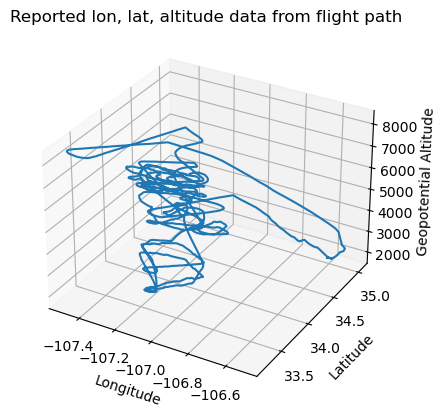

In [66]:
alt_vals = ds['ALT_GIN']
lat_vals = ds['LAT_GIN']
lon_vals = ds['LON_GIN']
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(lon_vals, lat_vals, alt_vals)
ax.scatter(lon_vals[0], lat_vals[0], alt_vals[0], c='Green', label='Start')
ax.scatter(lon_vals[-1], lat_vals[-1], alt_vals[-1], c='Red', label='Stop')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Geopotential Altitude')
plt.title('Reported lon, lat, altitude data from flight path')

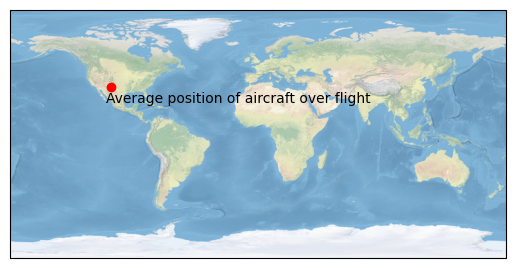

In [85]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

average_lon, average_lat = np.mean(lon_vals), np.mean(lat_vals)
plt.scatter(average_lon, average_lat, transform=ccrs.Geodetic(), c='r')
plt.text(average_lon - 3, average_lat - 12, 'Average position of aircraft over flight',
         horizontalalignment='left',
         transform=ccrs.Geodetic())

plt.show()

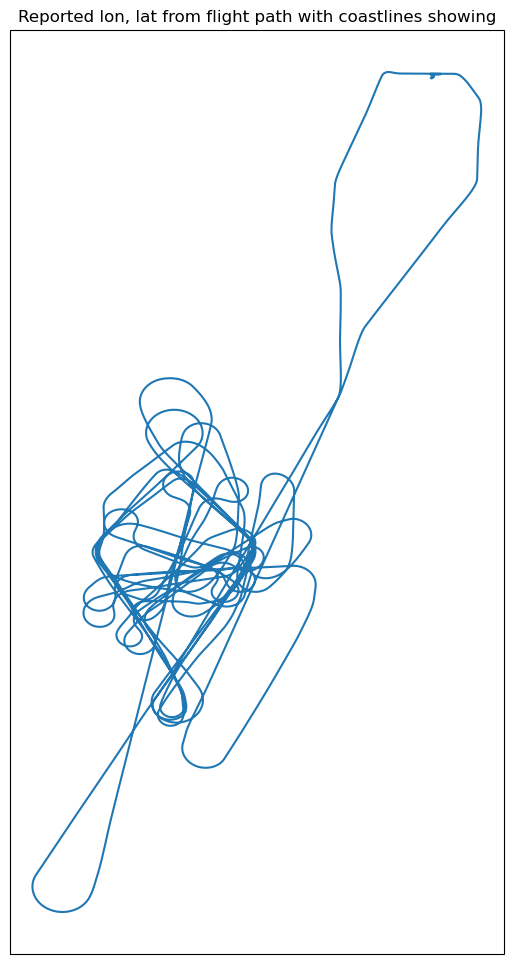

In [86]:
import cartopy.crs as ccrs
proj = ccrs.PlateCarree()  # cartopy projection
fig = plt.figure(figsize=(12, 12))  # size of plot
axes = plt.axes(projection=proj)  # plot transform
ax = plt.plot(lon_vals, lat_vals, transform=ccrs.PlateCarree())
plt.title('Reported lon, lat from flight path with coastlines showing')
axes.coastlines()  # show maplines

In [18]:
##### temp, old code from iris implementation of showing plots 
#####(no longer works due to metadata issues with current FAAM processed files)


# # <iris 'Cube' of altitude / (m) (-- : 21230; -- : 1)>,
# # <iris 'Cube' of latitude / (degree_north) (-- : 21230; -- : 1)>,
# # <iris 'Cube' of longitude / (degree_east) (-- : 21230; -- : 1)>,
# lon_vals = None
# lat_vals = None
# alt_vals = None
# for cube in cubes:
#     if cube.name()=='altitude':
#         alt_vals = cube.data
# for cube in cubes:
#     if cube.name()=='latitude':
#         lat_vals = cube.data
# for cube in cubes:
#     if cube.name()=='longitude':
#         lon_vals = cube.data
# print(lon_vals.shape)
# print(type(lon_vals))       
# lon_vals = np.ma.filled(lon_vals, np.NaN).flatten()
# lat_vals = np.ma.filled(lat_vals, np.NaN).flatten()
# alt_vals = np.ma.filled(alt_vals, np.NaN).flatten()

---

## References

If material in the notebook was adapted from other source material for NOAA, link to it.

Also, add other material either cited in the text or that extends content in the notebook.

### Acknowledgements